# Load Data

In [2]:
from fbprophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('aht.csv', usecols=range(5))
df.columns = ['bu', 'date', 'aht', 'time', 'volume']
df.head()

,bu,date,aht,time,volume
0,RAM,1/1/2019,1256,1213387.0,1014
1,RAM,1/2/2019,941,1870982.0,2012
2,RAM,1/3/2019,842,1363789.0,1667
3,RAM,1/4/2019,812,1803689.0,2290
4,RAM,1/7/2019,829,2377944.0,2876


# Process Data

In [3]:
df['date'] = pd.to_datetime(df['date'])
df['date'].describe()

/Users/dave-macbook/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  


count                    2150
unique                    430
top       2019-04-24 00:00:00
freq                        5
first     2019-01-01 00:00:00
last      2020-08-24 00:00:00
Name: date, dtype: object

In [4]:
df = df[df['time'].notnull()]

## Holidays?

get a list of holidays to exclude



In [5]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

dr = pd.date_range(start='2019-01-01', end='2020-08-24')
dr
df_ = pd.DataFrame()
df_['Date'] = dr

cal = calendar()
holidays = cal.holidays(start=dr.min(), end=dr.max())

df_['Holiday'] = df_['Date'].isin(holidays)
holidays = df_[df_['Holiday']==True]['Date']

In [6]:
df = df[~df['date'].isin(holidays)]

In [7]:
df.groupby()

(2073, 5)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe891af3e50>,
      dtype=object)

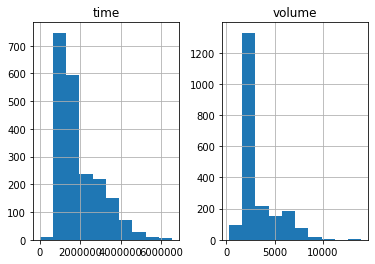

In [103]:
df[df['time']>1000].hist()

# Create Training Data and Fit Model

In [104]:
df['bu'].unique()

array(['RAM', 'RIS', 'WISE Contractual', 'Client Transactions',
       'Participant Transactions'], dtype=object)

In [105]:
df = df[df['bu']=='RAM'][['date','time']]

#  pre-format for prophet
df.columns = ['ds','y']

# set start date of training data
# df = df[df['ds'] >= '2018-07-01']
df.head()

,ds,y
1,2019-01-02,1870982.0
2,2019-01-03,1363789.0
3,2019-01-04,1803689.0
4,2019-01-07,2377944.0
5,2019-01-08,1817732.0


In [107]:
# create default prophet model
m = Prophet()
m.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


# Create future dates

In [108]:
future = m.make_future_dataframe(periods=90)
future.tail()

,ds
500,2020-11-18
501,2020-11-19
502,2020-11-20
503,2020-11-21
504,2020-11-22


# Make Predicitons on future dates

In [109]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
500,2020-11-18,2.008929e+06,1.572339e+06,2.418989e+06
501,2020-11-19,1.995166e+06,1.598989e+06,2.430914e+06
502,2020-11-20,1.950226e+06,1.535613e+06,2.369835e+06
503,2020-11-21,2.235654e+06,1.792357e+06,2.673381e+06
504,2020-11-22,2.234393e+06,1.754836e+06,2.618361e+06


# Visualize Data

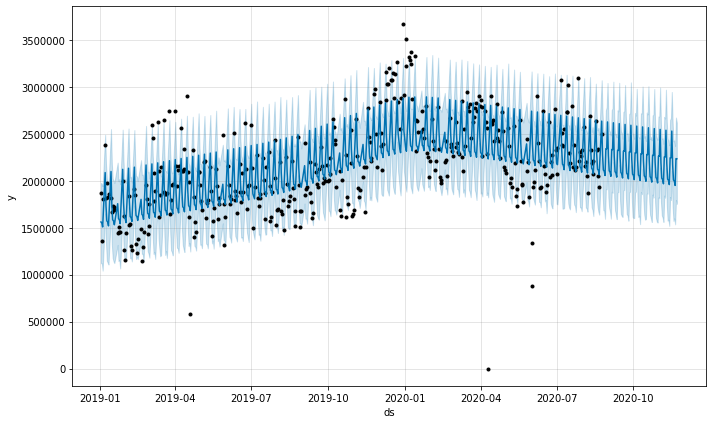

In [110]:
fig1 = m.plot(forecast)

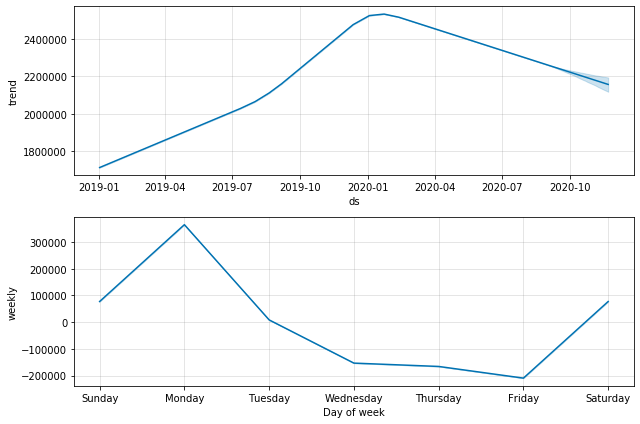

In [111]:
fig2 = m.plot_components(forecast)

# Calculate MAPE for original model and prophet 
from dates 2020-8-14 through 2020-8-19

In [19]:
f = forecast[(forecast['ds']>='2020-08-14') & (forecast['ds']<'2020-08-20')][['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# get rid of predictions on the weekends
f = f[(f['ds'] != '2020-08-15') & (f['ds'] != '2020-08-16')]

# get actual recent
f['actual'] = [1992,2690,2189,2196]

f['forecast'] = [1962,2844,2343,2137]

'prophet',abs((f['yhat']-f['actual'])/f['actual']).mean(), 'current model',abs((f['forecast'] - f['actual'])/f['actual']).mean()

('prophet', 0.03922814186119733, 'current model', 0.042382025338796786)

In [20]:
# Create display dataframe for results
d = f[['ds','yhat','actual','forecast']].copy()
d['yhat'] = d['yhat'].round()
d.columns = ['date', 'prediction', 'actual', 'forecast']
d

,date,prediction,actual,forecast
532,2020-08-14,1933.0,1992,1962
535,2020-08-17,2781.0,2690,2844
536,2020-08-18,2235.0,2189,2343
537,2020-08-19,2037.0,2196,2137
